 #  Imports

## Modules and libraries

In [1]:
# Necessarily early imports
import numpy as np, random
# Ensure deterministic output
np.random.seed(137)
random.seed(137)
import warnings
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings(
    "ignore",
    category=CryptographyDeprecationWarning,
    module=r"paramiko.*",
)

# Local imports
from utils.preprocess_data_utils import *
from utils.read_utils import *
from utils.evaluate_clustering_utils import *

# External imports
# Basic libraries and modules
import os
import pandas as pd
import multiprocessing as mp
import ast
import random
# Specialized libraries and modules
import scanpy as sc
import muon as mu

# Suppress chatter
# Suppress deprecation, efficiency, and verbose plotting warnings for clean output
sc.settings.verbosity = 0
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning) # working with df copy warning, ignore for now, might be important later
warnings.simplefilter('ignore', SparseEfficiencyWarning) # warning for inefficient matrix modification after filtering genes
warnings.filterwarnings("ignore", message=".*looks like a single numeric RGB or RGBA sequence.*") # UMAP warnings
warnings.filterwarnings("ignore", message=".*More than 20 figures have been opened")

## Data

In [2]:
# Dictionary with data file practical labels and file names
fileNameDict = {
    'gene_count': 'gene_counts.csv',
    'cell_metadata': 'cell_meta_data.csv',
    'cell_assignment': 'cell_assignment.csv',
    'embedding1': 'baysor_model_inference_VSTE-328.csv',
    'embedding2': 'staining_crops_model_inference_VSTE-322.csv',
    'embedding3': 'baysor_model_inference_VSTE-347.csv',
    'embedding4': 'baysor_model_inference_VSTE-350.csv',
    'cp_100': 'data_crop100.db',
    'cp_300': 'data_crop300.db'
}

# Main directories
inputDir = '../data_restructured'
outputDir = '../analysis_output/final/gene_subset_analyses'

# Reading data files into dfs
# Initializing raw df dict
rawDFDict = {}
for label, fileName in fileNameDict.items():
    # Importing all CSVs
    if fileName.endswith('csv'):
        rawDFDict[label] =  load_csv_to_df(parent_path=inputDir, file_name=fileName, index_col=0)
    # Importing SQLite DBs (CP feature data), separated into per object and per image DFs
    # These come from CellProfiler and will later be merged for downstream use
    elif fileName.endswith('db'):
        tempDF = load_db_to_df_dict(parent_path=inputDir, file_name=fileName)
        rawDFDict[label + '_perObj'] = tempDF['Per_Object']
        rawDFDict[label + '_perImg'] = tempDF['Per_Image']

# Preprocessing

In [3]:
# Checking if post-PyCytominer CP data exists in output folder (to avoid non-deterministic nature of feature selection)
# If files exist, use them directly instead of re-merging & filtering features
cpExists = False
os.makedirs(outputDir + '/CP_after_pcm', exist_ok=True)
cp100Path = outputDir + '/CP_after_pcm/cp100.csv'
cp300Path = outputDir + '/CP_after_pcm/cp300.csv'
if os.path.isfile(cp100Path) and os.path.isfile(cp300Path):
    cpExists = True

# Initializing preprocessed df dict as a copy of the raw dict except the CP feature keys
keys2Exclude = ['cp_100', 'cp_300']
preprocessedDFDict = {key: value for key, value in rawDFDict.items() if not any(substring in key for substring in keys2Exclude)}

# Setting cell_index as index as a guard
for key, df in preprocessedDFDict.items():
    if 'cell_index' in df.columns:
        preprocessedDFDict[key] = df.set_index('cell_index')

if not cpExists:
    # Merging the CP feature DFs (first output. Otherwise, take second output for list of tuples of identical columns removed if desired)
    preprocessedDFDict['cp_100'] = merge_df_unq_cols_by_val(df1=rawDFDict['cp_100_perObj'], df2=rawDFDict['cp_100_perImg'], suffixes=('_perObj', '_perImg'))[0]
    preprocessedDFDict['cp_300'] = merge_df_unq_cols_by_val(df1=rawDFDict['cp_300_perObj'], df2=rawDFDict['cp_300_perImg'], suffixes=('_perObj', '_perImg'))[0]

# Processing cell_assignment_df (renaming, dropping 'removed' cell types and such), before common-index filtering or generating intersection matrix
tempDF = rawDFDict['cell_assignment'] # temporary assignment to preprocess the raw ground truth df
tempDF.rename(columns={"leiden_final": "cell_type"}, inplace=True)
# Drop cells assigned "Removed" from the cell_assignment DF, these are filtered out of downstream analysis entirely
gtClusteringDF = tempDF[tempDF['cell_type'] != 'Removed']
# Assign cell type numbers
unqCellTypes = gtClusteringDF['cell_type'].unique()
cellTypeMapping = {cell_type: index + 1 for index, cell_type in enumerate(unqCellTypes)}
gtClusteringDF['cell_type_number'] = gtClusteringDF['cell_type'].map(cellTypeMapping)
# Overwriting cell_assignment df in the preprocessed dict, copied from the raw dict
preprocessedDFDict['cell_assignment'] = gtClusteringDF

# Filtering DFs to common indices (first output. Take second output for list of common indices if desired)
preprocessedDFDict = filter_to_common_indices(dataframe_dictionary=preprocessedDFDict)[0]

if not cpExists:
    # Filtering CP data by removing irrelevant features/metadata columns
    # List of KWs that, if contained in column names, are removed
    cpColExclKWList = [
        'meta',
        'index',
        'imagenumber',
        '_y_',
        '_x_'
    ]

    preprocessedDFDict['cp_100'] = drop_irrelevant_cols(dataframe=preprocessedDFDict['cp_100'], col_name_kw_list=cpColExclKWList)[0]
    preprocessedDFDict['cp_300'] = drop_irrelevant_cols(dataframe=preprocessedDFDict['cp_300'], col_name_kw_list=cpColExclKWList)[0]

    # Exporting cleaned up CP data to ensure determinism
    preprocessedDFDict['cp_100'].to_csv(cp100Path, index=True)
    preprocessedDFDict['cp_300'].to_csv(cp300Path, index=True)
else:
    preprocessedDFDict['cp_100'] = pd.read_csv(cp100Path, index_col=0)
    preprocessedDFDict['cp_300'] = pd.read_csv(cp300Path, index_col=0)


# Adjusting latent variable names by prefixing with 'z_'
preprocessedDFDict = adjust_latent_var_names(dataframe_dictionary=preprocessedDFDict)

## Creating AnnData objects

In [4]:
# List of keys referencing DFs to create AnnData objects from. 
DFKey4AdObjList = [
    'gene_count',
    'embedding2',
    'cp_100',
    'cp_300'
]

# Creating AnnData objects using a helper utils fxn
adObjDict = create_anndata_obj(dataframe_dictionary=preprocessedDFDict, cell_metadata_df=preprocessedDFDict['cell_metadata'], dataframe_key_list=DFKey4AdObjList, indices_to_concatenate=None)

# Adding spatial information, needed for plotting spatial embeddings
spatialCellCoords = preprocessedDFDict['cell_metadata'][['x', 'y']].values
for key, obj in adObjDict.items():
    obj.obsm['spatial'] = np.transpose(spatialCellCoords.transpose())

# Normalizing and log transforming transcript count AnnData object
tcAdObj = adObjDict['gene_count']
sc.pp.normalize_total(tcAdObj, inplace=True)
sc.pp.log1p(tcAdObj)

## Creating MuData object

In [5]:
# MuData object containing each dataset as a modality. An alternative to a dictionary of AnnData objects. In this case, the object contains only the TC feature space as the goal is to optimize clustering hyperparameters for TC (whole feature set) in order to use that clustering to find the top genes (for one of the subsetting approaches). Post-subsetting hyperparam optimization is run downstream
mdObjAll = mu.MuData({
    'TC': adObjDict['gene_count'],
})

# Clustering TC

## Finding optimal clustering hyperparameters (for the full feature space of TC)

In [6]:
# Creating optimization worker fxn
def AnnData_optimization_worker_fxn(args):
    # Unpacking args
    key, object, metadata = args

    # Ensure no NaNs (relevant for CP data where NaNs are extremely rare)
    object.X = np.nan_to_num(object.X, nan=np.nanmean(object.X, axis=0))

    # Optimizing k and resolution hyperparameters
    optimalHyperparams = optimize_leiden_hyperparams(object, min_clusters=metadata['AnnData_min_clusters'], k_range=metadata['AnnData_k_range'], resolution_range=metadata['AnnData_resolution_range'], resolution_threshold=metadata['AnnData_resolution_threshold'], increment_multiple_after_threshold=metadata['AnnData_increment_multiple_after_threshold'])

    return key, optimalHyperparams

# Checking if optimization was already done and the hyperparameter csv exists
optimizationDone = False
os.makedirs(outputDir + '/optimization', exist_ok=True)
adOptimizedHyperparamsPath = outputDir + '/optimization/AnnData_optimal_leiden_hyperparams.csv'
if os.path.isfile(adOptimizedHyperparamsPath):
    optimizationDone = True

# Initializing dictionary
optimalLeidenHyperparamsDict = {
    'AnnData': {
        'metadata': {
            'AnnData_min_clusters' : 5,
            'AnnData_k_range': (5,50,5),
            'AnnData_resolution_range': (0.5,10,0.05),
            'AnnData_resolution_threshold': 1,
            'AnnData_increment_multiple_after_threshold': 20
        },
        'results': {}
    },
    'MuData': {
        'metadata': {},
        'results': {}
    }
}

if not optimizationDone:
    # Parallelizing optimization
    if __name__ == "__main__":
        # Prepare arguments for worker fxn
        metadata = optimalLeidenHyperparamsDict['AnnData']['metadata']
        argsList = [(key, obj, metadata) for key, obj in mdObjAll.mod.items()]

        # Run in parallel using multiprocessing.Pool
        with mp.Pool() as pool:
            results = pool.map(AnnData_optimization_worker_fxn, argsList)

        # Aggregate results
        for key, mdObjOptimalLeidenHyperparams in results:
            optimalLeidenHyperparamsDict['AnnData']['results'][key] = mdObjOptimalLeidenHyperparams.copy()

        # Exporting optimal hyperparameters
        pd.DataFrame.from_dict(optimalLeidenHyperparamsDict['AnnData'], orient='index').to_csv(adOptimizedHyperparamsPath)
        
# If optimization was already ran, load data into the dict
else:
    optimalLeidenHyperparamsDict['AnnData'] = pd.read_csv(adOptimizedHyperparamsPath, index_col=0).to_dict(orient='index')
    # Clean up, filtering NaNs from nested dictionary
    optimalLeidenHyperparamsDict['AnnData']['metadata'] = {k: v for k, v in optimalLeidenHyperparamsDict['AnnData']['metadata'].items() if not (isinstance(v, float) and pd.isna(v))}
    optimalLeidenHyperparamsDict['AnnData']['results'] = {k: v for k, v in optimalLeidenHyperparamsDict['AnnData']['results'].items() if not (isinstance(v, float) and pd.isna(v))}

# Isolating top ranked and random gene subsets

### Conducting PCA for PCA-approach to selecting top genes

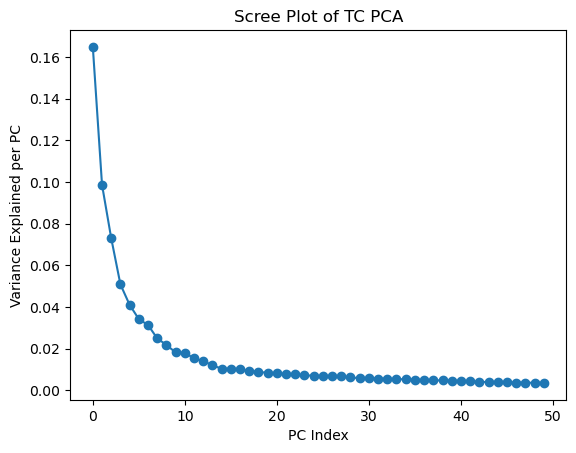

In [7]:
# Running PCA
sc.pp.pca(mdObjAll.mod['TC'])

# Extract variance explained per PC
varianceExplained = mdObjAll.mod['TC'].uns['pca']['variance_ratio']

# Scree plot for the elbow method (15 PCs chosen)
plt.plot(varianceExplained, marker="o")
plt.xlabel("PC Index")
plt.ylabel("Variance Explained per PC")
plt.title("Scree Plot of TC PCA")

# Export
os.makedirs(outputDir + '/stats', exist_ok=True)
screePlotPath = outputDir + '/stats/scree_plot.png'
plt.savefig(screePlotPath, bbox_inches='tight', dpi=600)

### Finding top genes

In [8]:
# Adding true labels as a ground truth partition
mdObjAll.mod['TC'].obs['true_label_clusters'] = preprocessedDFDict['cell_assignment']['cell_type'].values

# Isolating gene lists
with warnings.catch_warnings(): # Get rid of warning about log2 fold change calculation
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # Fetching top genes contributing to each cluster based on true labels, using helper utils fxn
    nGenesPerTrueLabel = 1
    topGenesAsPerGTDict = top_n_genes_per_cluster(AnnData_object=mdObjAll.mod['TC'], n_genes=nGenesPerTrueLabel, clustering_obs_key='true_label_clusters')
    
    # Isolating top genes per top PCs
    nGenesPerPC = 3
    nPCs = 15 
    # Get PCA loadings
    loadings = mdObjAll.mod['TC'].varm['PCs'][:, :nPCs]
    # Convert to DF
    genes = mdObjAll.mod['TC'].var_names
    loadingsDF = pd.DataFrame(loadings, index=genes, columns=[f"PC{i + 1}" for i in range(nPCs)])
    # Select top nGenes for each PC
    topGenesPerPCDict = {}
    for pc in loadingsDF.columns:
        topGenesPerPCDict[pc] = loadingsDF[pc].abs().nlargest(nGenesPerPC).index.tolist()
    # Flatten into unique list
    topPCAGenesList = list(set([gene for genes in topGenesPerPCDict.values() for gene in genes]))

    # Isolating random genes (nGenes = number of clusters obtained by Leiden)
    nGenesRandom = mdObjAll.mod['TC'].obs['true_label_clusters'].nunique() * nGenesPerTrueLabel
    randomGenesList = random.sample(list(mdObjAll.mod['TC'].var_names), nGenesRandom)

# Converting top gene dictionary to list
topGTGenesList = [gene for genes in topGenesAsPerGTDict.values() for gene in genes]

# Generating list of genes to drop
genes2DropNonTopGT = [gene for gene in mdObjAll.mod['TC'].var_names if gene not in topGTGenesList]
genes2DropNonTopPCA = [gene for gene in mdObjAll.mod['TC'].var_names if gene not in topPCAGenesList]
genes2DropRandom = [gene for gene in mdObjAll.mod['TC'].var_names if gene not in randomGenesList]

## Filtering data objects to drop genes

In [9]:
# Dropping features (genes) using helper utils fxn and adding to MuData object
mdObjAll.mod['GT-Based Subset'] = filter_features(AnnData_object=mdObjAll.mod['TC'], features_to_drop=genes2DropNonTopGT)
mdObjAll.mod['PCA-Based Subset'] = filter_features(AnnData_object=mdObjAll.mod['TC'], features_to_drop=genes2DropNonTopPCA)
mdObjAll.mod['Random Subset'] = filter_features(AnnData_object=mdObjAll.mod['TC'], features_to_drop=genes2DropRandom)

# Deleting full feature TC object
del mdObjAll.mod['TC']

# Adding other individual modalities to MuData object
mdObjAll.mod['LS2'] = adObjDict['embedding2']
mdObjAll.mod['CPsm'] = adObjDict['cp_100']
mdObjAll.mod['CPlg'] = adObjDict['cp_300']

# Clustering individual TC subsets, LS2, and CP-features

## Finding optimal clustering hyperparameters

In [10]:
# Keeping code consistent with other full-feature notebook, but running asynchronously as this cell is too far down in the notebook and overhead is too high
# Creating worker fxn
def AnnData_optimization_worker_fxn(args):
    # Unpacking args
    key, object, metadata = args
    
    # Ensure no NaNs (relevant for CP data)
    object.X = np.nan_to_num(object.X, nan=np.nanmean(object.X, axis=0))
    
    # Optimizing k and resolution hyperparameters
    optimalHyperparams = optimize_leiden_hyperparams(object, min_clusters=metadata['AnnData_min_clusters'], k_range=metadata['AnnData_k_range'], resolution_range=metadata['AnnData_resolution_range'], resolution_threshold=metadata['AnnData_resolution_threshold'], increment_multiple_after_threshold=metadata['AnnData_increment_multiple_after_threshold'])
    
    return key, optimalHyperparams

# Checking if optimization was already done and the hyperparameter csv exists
optimizationDone = False
os.makedirs(outputDir + '/optimization', exist_ok=True)
adOptimizedHyperparamsPath = outputDir + '/optimization/AnnData_optimal_leiden_hyperparams_subsets_with_PCA.csv'
if os.path.isfile(adOptimizedHyperparamsPath):
    optimizationDone = True

# Initializing dictionary
optimalLeidenHyperparamsDict = {
    'AnnData': {
        'metadata': {
            'AnnData_min_clusters' : 5,
            'AnnData_k_range': (5,50,5),
            'AnnData_resolution_range': (0.5,10,0.05),
            'AnnData_resolution_threshold': 1,
            'AnnData_increment_multiple_after_threshold': 20
        },
        'results': {}
    },
    'MuData': {
        'metadata': {},
        'results': {}
    }
}

if not optimizationDone:
    # Sequentially optimizing
    metadata = optimalLeidenHyperparamsDict['AnnData']['metadata']
    argsList = [(key, obj, metadata) for key, obj in mdObjAll.mod.items()]
    
    results = []
    for args in argsList:
        results.append(AnnData_optimization_worker_fxn(args))
    
    # Aggregate results
    for key, mdObjOptimalLeidenHyperparams in results:
        optimalLeidenHyperparamsDict['AnnData']['results'][key] = mdObjOptimalLeidenHyperparams.copy()
    
    # Exporting optimal hyperparameters
    pd.DataFrame.from_dict(optimalLeidenHyperparamsDict['AnnData'], orient='index').to_csv(adOptimizedHyperparamsPath)

else:
    optimalLeidenHyperparamsDict['AnnData'] = pd.read_csv(adOptimizedHyperparamsPath, index_col=0).to_dict(orient='index')
    # Clean up, filtering NaNs from nested dictionary 
    optimalLeidenHyperparamsDict['AnnData']['metadata'] = {k: v for k, v in optimalLeidenHyperparamsDict['AnnData']['metadata'].items() if not (isinstance(v, float) and pd.isna(v))}
    optimalLeidenHyperparamsDict['AnnData']['results'] = {k: v for k, v in optimalLeidenHyperparamsDict['AnnData']['results'].items() if not (isinstance(v, float) and pd.isna(v))}


## Clustering individual modalities using optimal Leiden hyperparameters

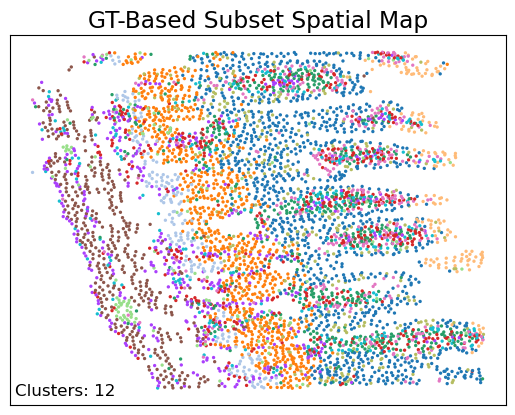

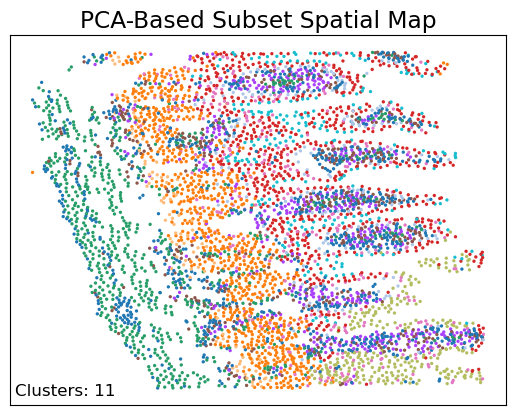

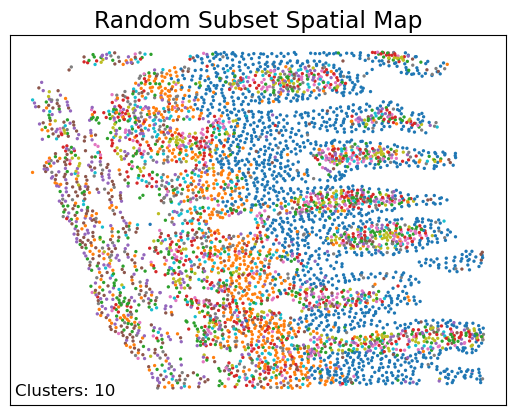

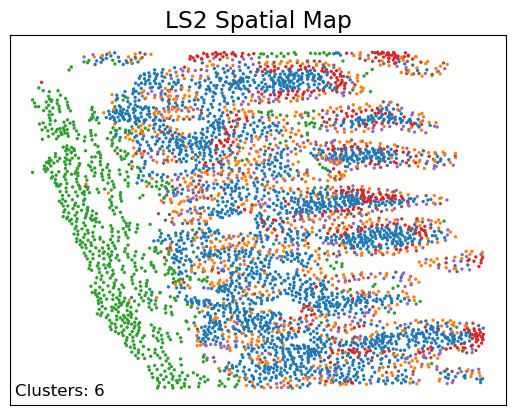

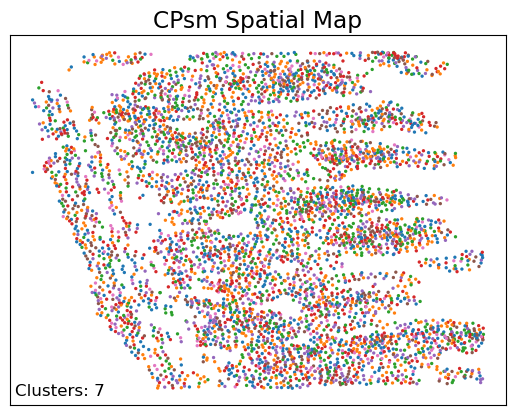

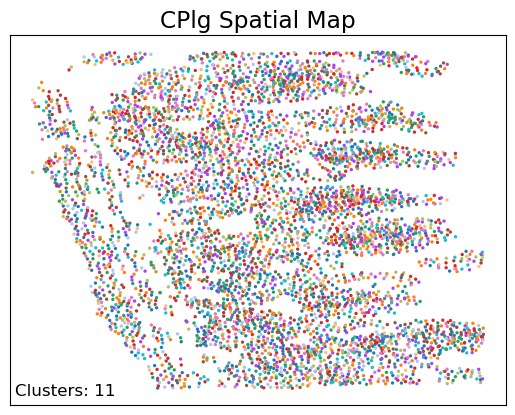

In [31]:
for key, obj in mdObjAll.mod.items():
    # Ensure no NaNs (relevant for CP data)
    obj.X = np.nan_to_num(obj.X, nan=np.nanmean(obj.X, axis=0))

    # Clearing previous clustering data as a precaution
    tempDict = {key: obj}
    clear_clustering_data(tempDict)
    
    # Args. Setting nPCs to 0 forces clustering of data itself and not representation. n_neighbors (k) param for Leiden clustering.
    nPCs = 0
    # Converting str to dictionary in case the optimal hyperparameters were imported from a previous run
    if isinstance(optimalLeidenHyperparamsDict['AnnData']['results'][key], str):
        optimalLeidenHyperparamsDict['AnnData']['results'][key] = ast.literal_eval(optimalLeidenHyperparamsDict['AnnData']['results'][key])
    # Setting the two optimized Leiden hyperparams (n_neighbors, i.e. k in k-NN, and resolution, i.e. gamma in the objective modularity fxn)  
    nNeighbors = optimalLeidenHyperparamsDict['AnnData']['results'][key]['n_neighbors']
    resolution = optimalLeidenHyperparamsDict['AnnData']['results'][key]['resolution']
    
    # Running k-NN generation and Leiden clustering
    sc.pp.neighbors(obj, n_neighbors=nNeighbors, n_pcs=nPCs, random_state=137)
    sc.tl.leiden(obj, key_added='clusters', resolution=resolution)
    sc.pl.embedding(obj, basis="spatial", color="clusters", title=f"{key} Spatial Map", legend_loc='none', show=False)
    # Adding title manually since (to resolve inconsistency due to different implementation of sc vs mu)
    plt.gca().set_title(f"{key} Spatial Map", fontsize=16.8)

    # Adding nClusters as text
    nClusters = obj.obs['clusters'].nunique()
    plt.gca().text(0.01, 0.02, f'Clusters: {nClusters}',
                   horizontalalignment='left',
                   verticalalignment='bottom',
                   transform=plt.gca().transAxes,
                   fontsize=12, color='black')
    # Dropping axis titles
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("")
    
    os.makedirs(outputDir + '/spatial', exist_ok=True)
    fileName = key.replace(' ', '_')
    indivModSpatialMapPath = outputDir + f'/spatial/{fileName}_spatial_map.png'
    plt.savefig(indivModSpatialMapPath, dpi=600, bbox_inches="tight")

## Evaluating individual modality clustering

Exported cluster correlation DataFrame to ../analysis_output/final/gene_subset_analyses/individual_modality_metrics/cluster_correl_combined.csv


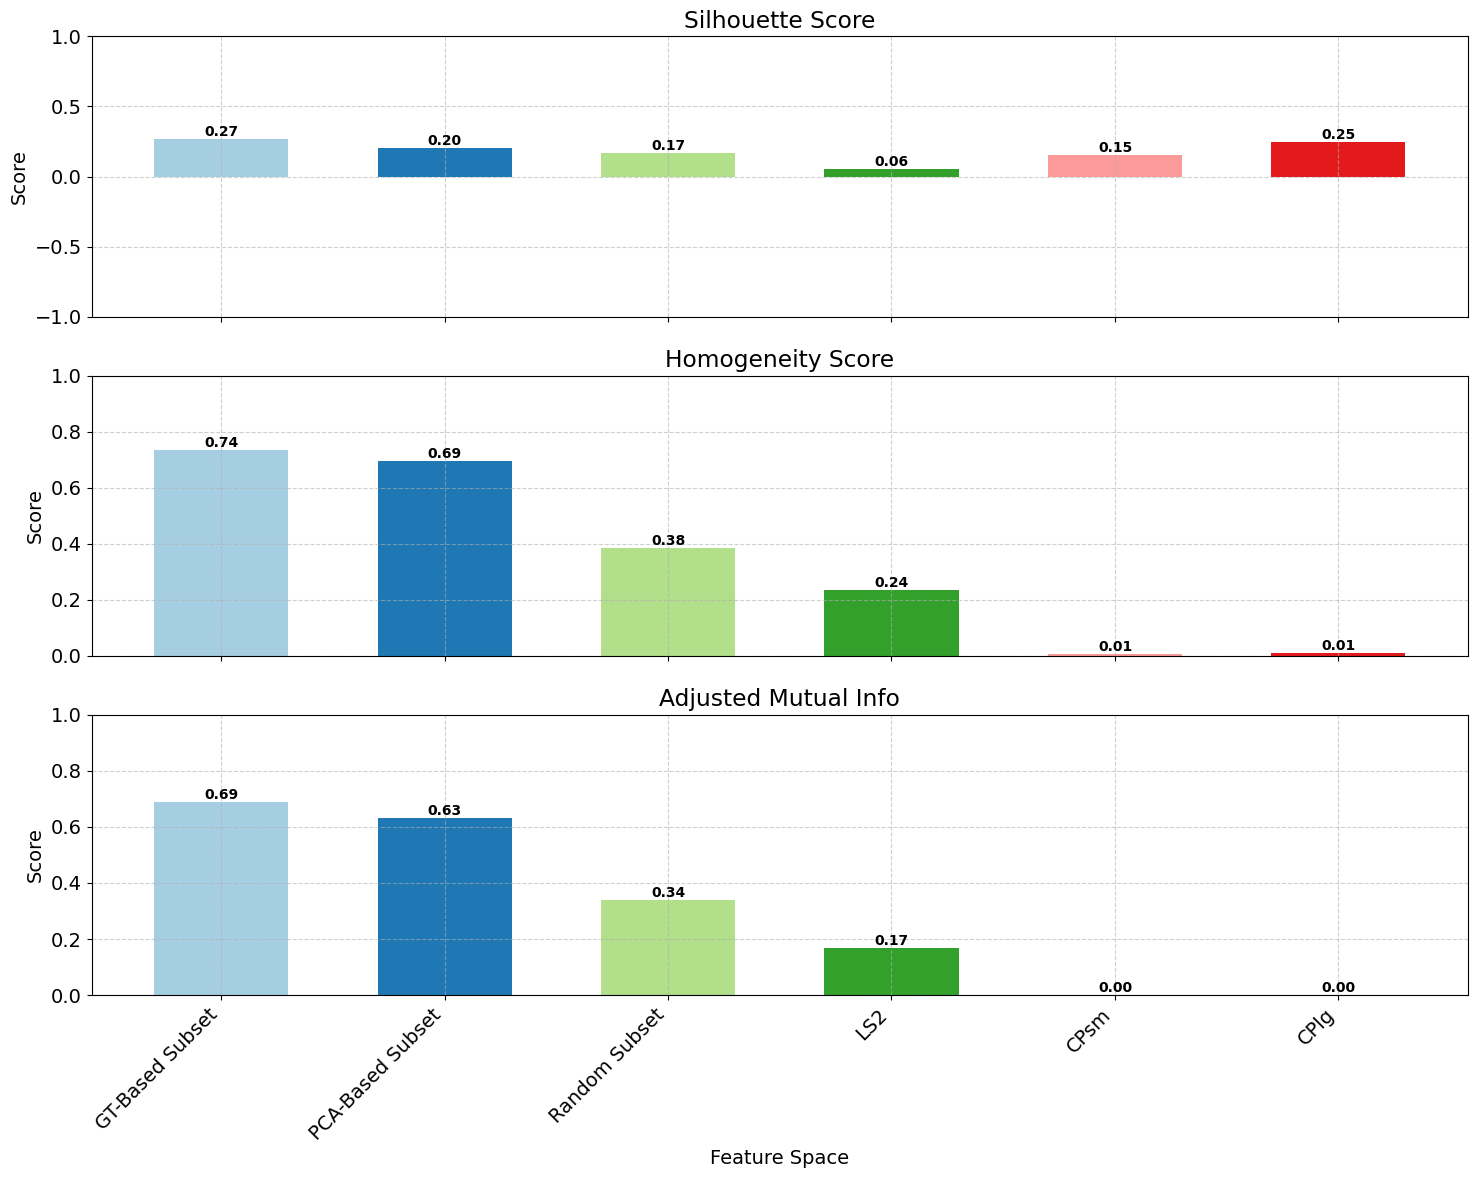

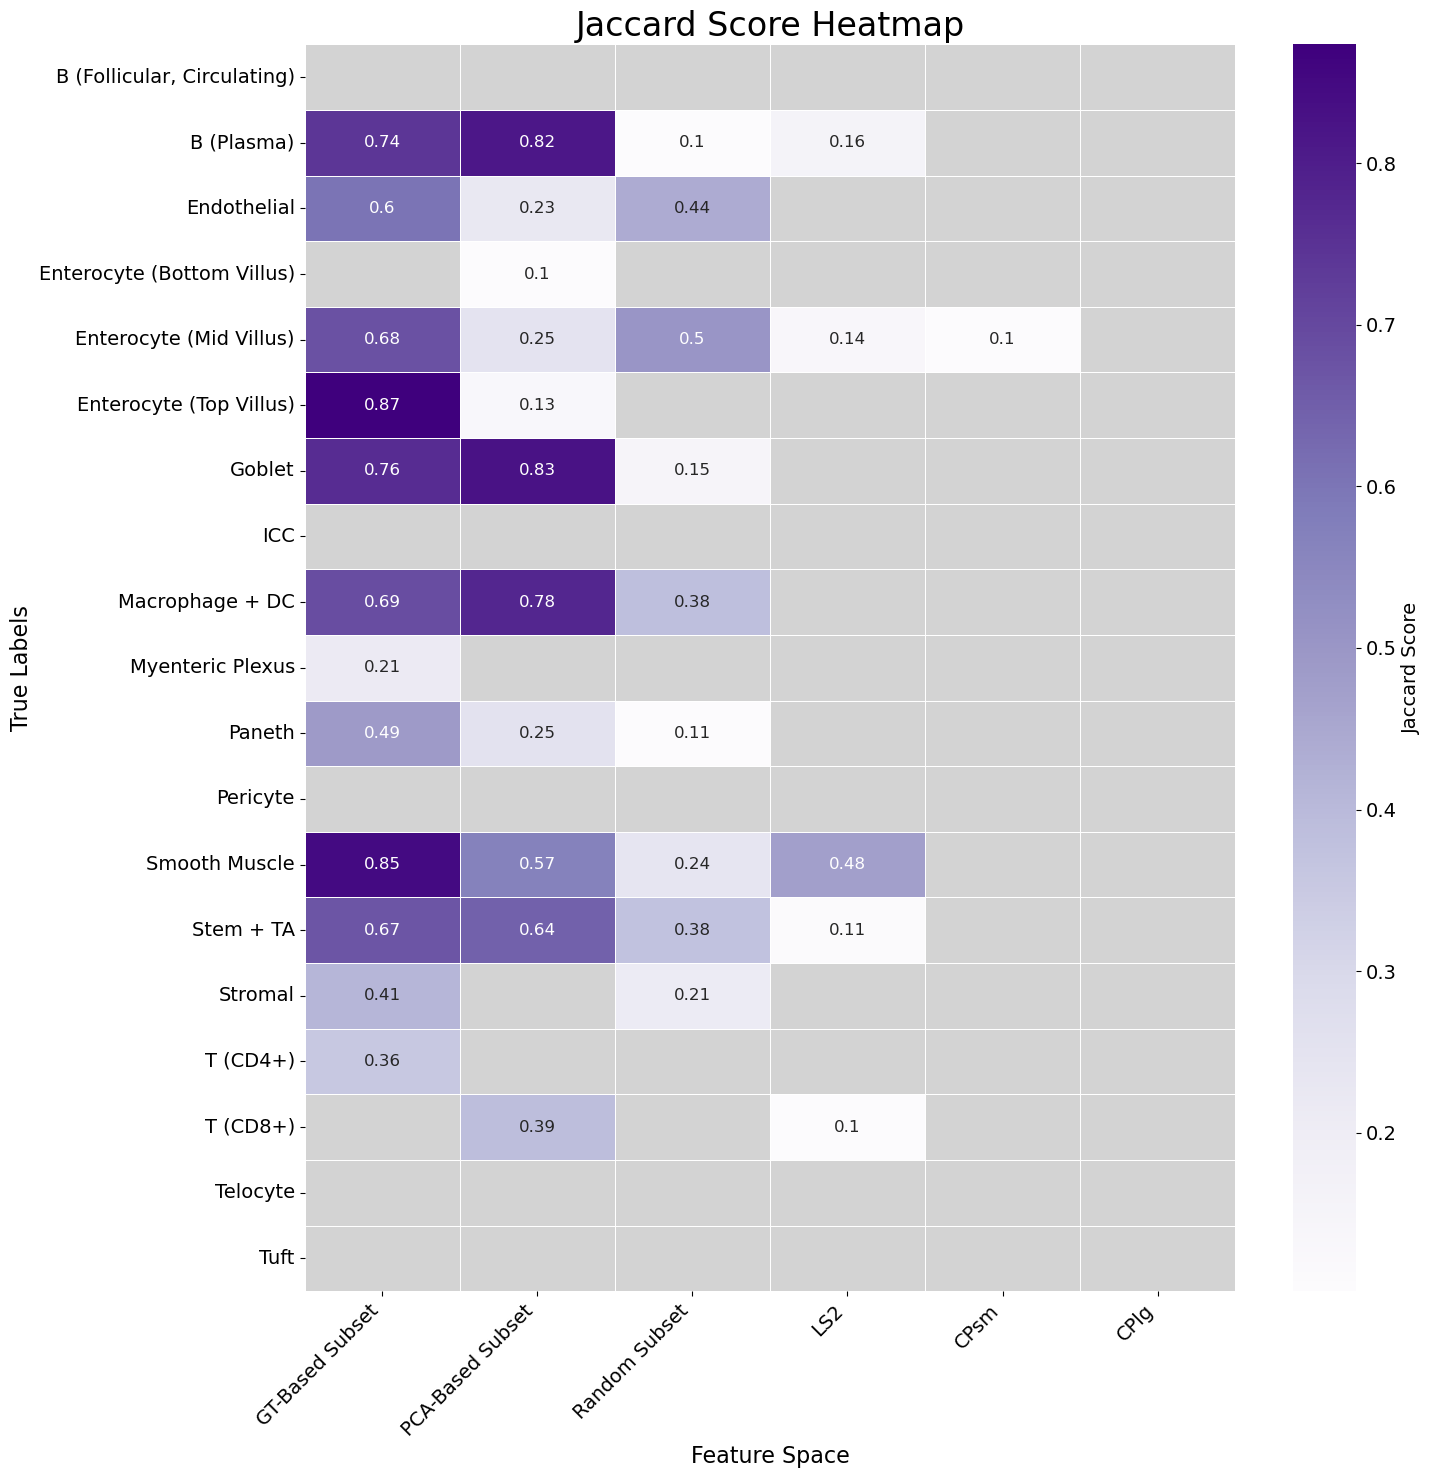

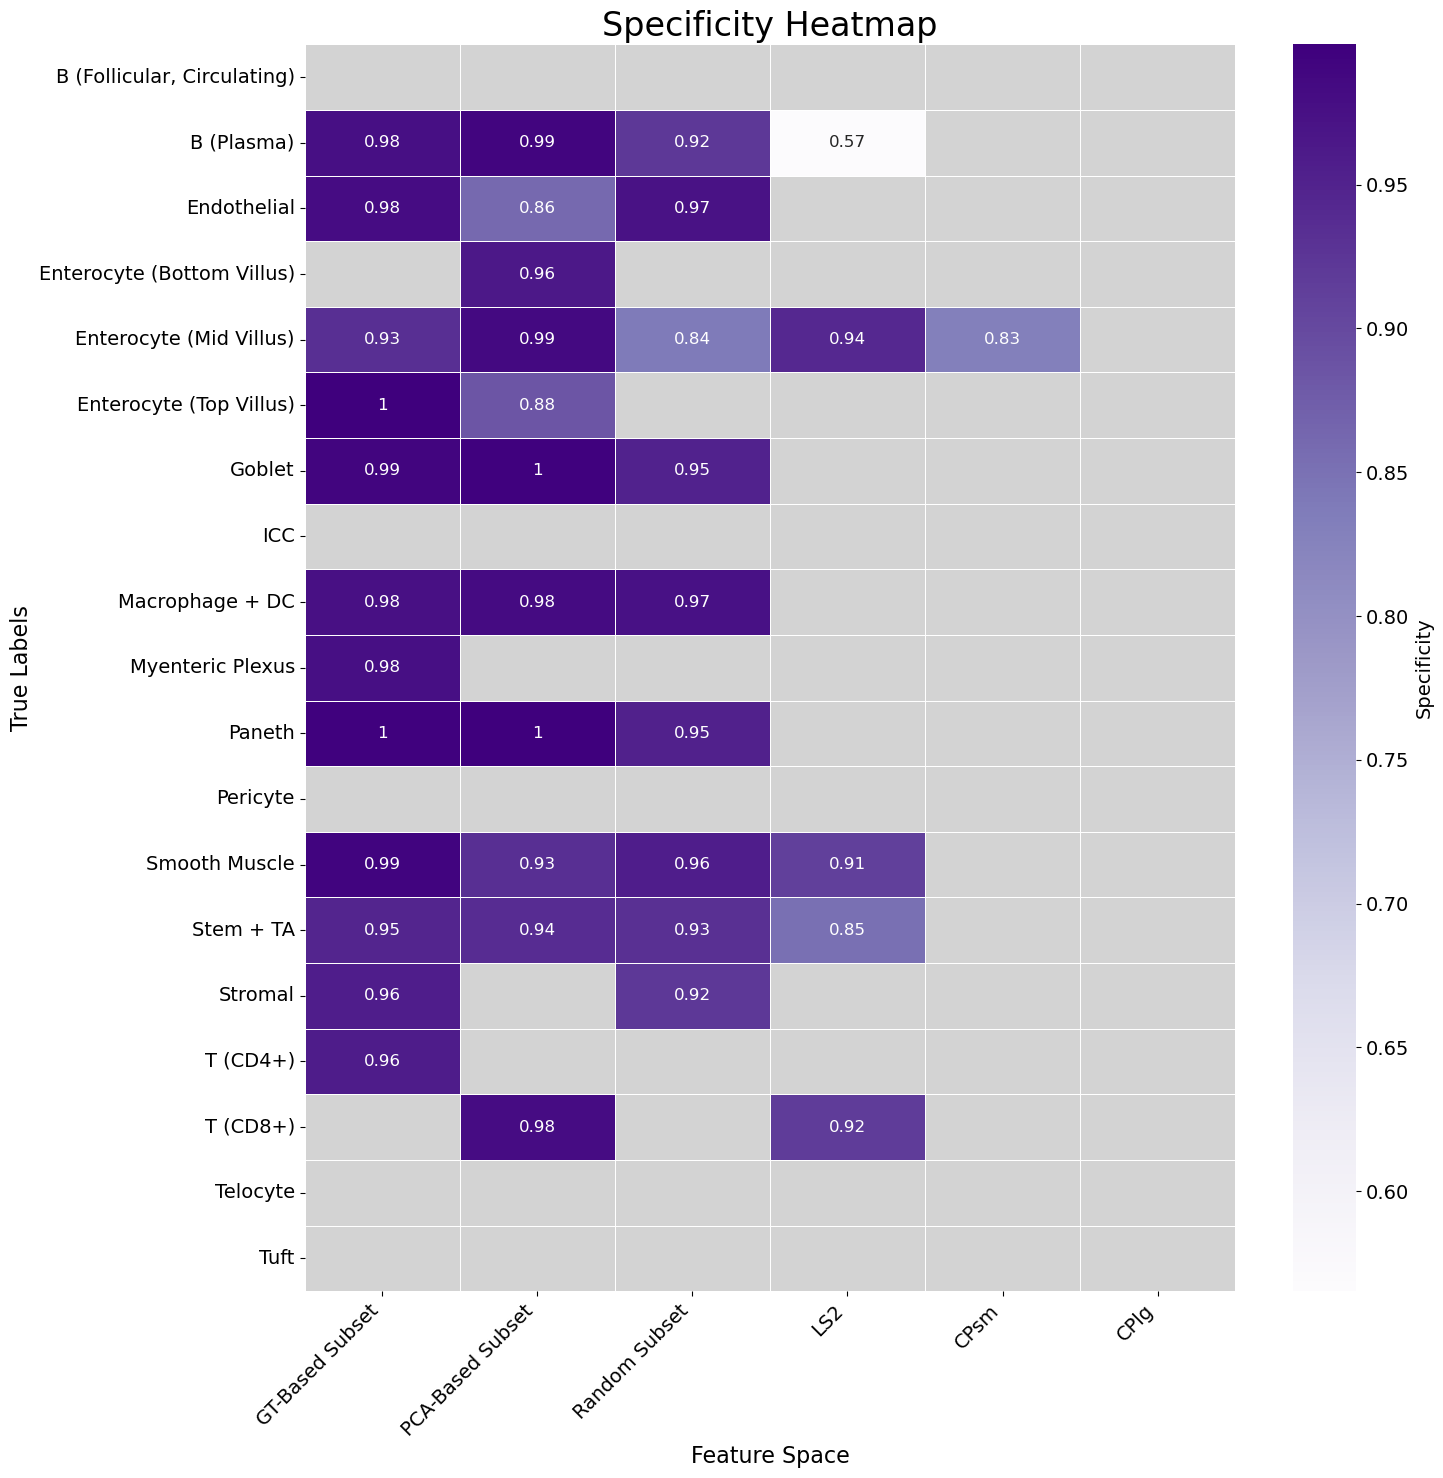

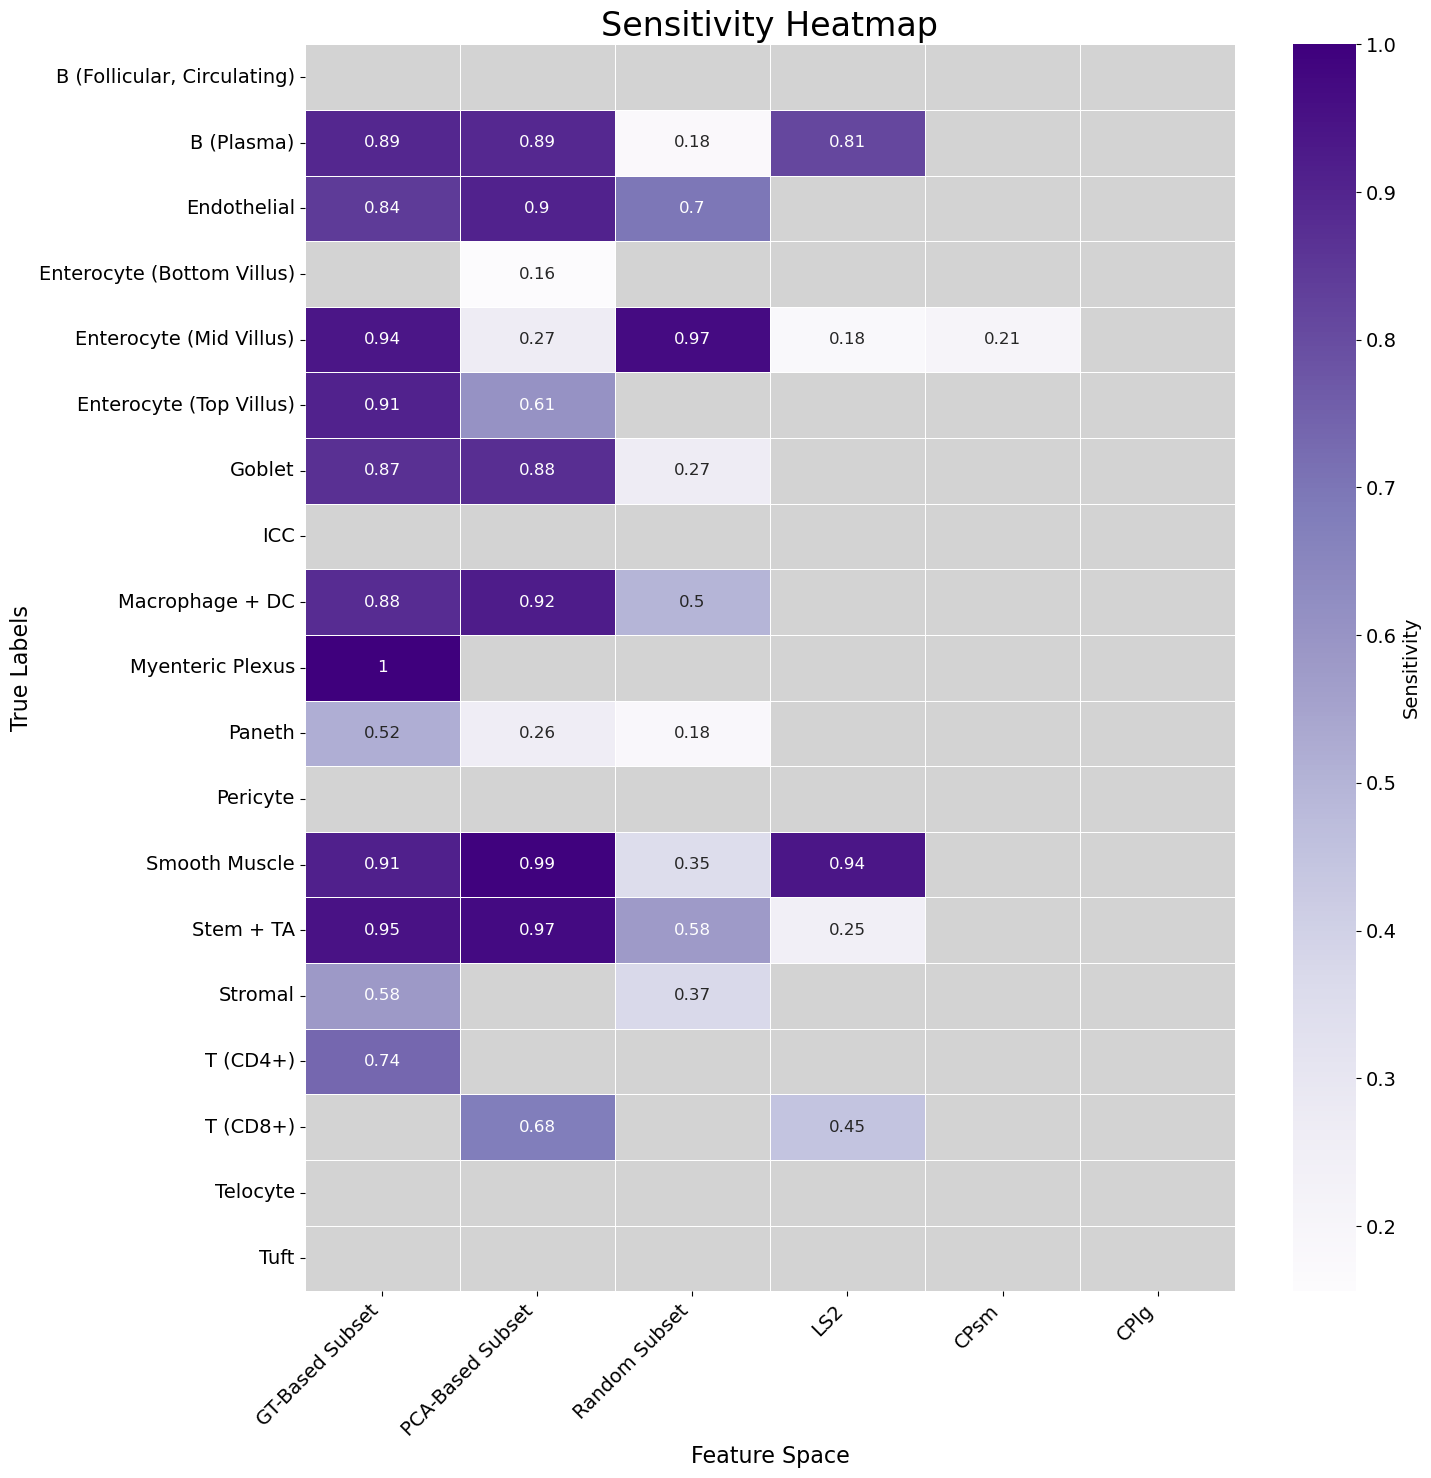

In [24]:
# Making a directory for individual modality analyses
os.makedirs(outputDir + '/individual_modality_metrics', exist_ok=True)
indivOutputDir = outputDir + '/individual_modality_metrics'

datasetCustomOrderList = ['GT-Based Subset', 'PCA-Based Subset', 'Random Subset', 'LS2', 'CPsm', 'CPlg']

# Clustering metrics for individual datasets
evaluate_clustering(data_object_dictionary=mdObjAll.mod, ground_truth_dataframe=preprocessedDFDict['cell_assignment'], output_directory=indivOutputDir, sort_labels=False, generate_interaction_plots=False, generate_specificity_heatmap=True, generate_sensitivity_heatmap=True, dataset_custom_order_list=datasetCustomOrderList, color_map='Purples')

# Clustering combined modalities

## Creating MuData objects

In [25]:
# MuData objects for each dataset combination
# Gene subset with LS2
mdObj_top_GT_TC_LS2 = mu.MuData({
    'GT-Based Subset': mdObjAll.mod['GT-Based Subset'],
    'LS2': adObjDict['embedding2']
})

mdObj_top_PCA_TC_LS2 = mu.MuData({
    'PCA-Based Subset': mdObjAll.mod['PCA-Based Subset'],
    'LS2': adObjDict['embedding2']
})

mdObj_top_rand_TC_LS2 = mu.MuData({
    'Random Subset': mdObjAll.mod['Random Subset'],
    'LS2': adObjDict['embedding2']
})


# Gene subset with CP small crop
mdObj_top_GT_TC_CPsm = mu.MuData({
    'GT-Based Subset': mdObjAll.mod['GT-Based Subset'],
    'CPsm': adObjDict['cp_100']
})

mdObj_top_PCA_TC_CPsm = mu.MuData({
    'PCA-Based Subset': mdObjAll.mod['PCA-Based Subset'],
    'CPsm': adObjDict['cp_100']
})

mdObj_top_rand_TC_CPsm = mu.MuData({
    'Random Subset': mdObjAll.mod['Random Subset'],
    'CPsm': adObjDict['cp_100']
})

# Gene subset with CP large crop
mdObj_top_GT_TC_CPlg = mu.MuData({
    'GT-Based Subset': mdObjAll.mod['GT-Based Subset'],
    'CPlg': adObjDict['cp_300']
})

mdObj_top_PCA_TC_CPlg = mu.MuData({
    'PCA-Based Subset': mdObjAll.mod['PCA-Based Subset'],
    'CPlg': adObjDict['cp_300']
})

mdObj_top_rand_TC_CPlg = mu.MuData({
    'Random Subset': mdObjAll.mod['Random Subset'],
    'CPlg': adObjDict['cp_300']
})

# Dictionary with combinatorial MuData objects
mdObjComboDict = {
    'GT-Based Subset + LS2': mdObj_top_GT_TC_LS2,
    'PCA-Based Subset + LS2': mdObj_top_PCA_TC_LS2,
    'Random Subset + LS2': mdObj_top_rand_TC_LS2,
    'GT-Based Subset + CPsm': mdObj_top_GT_TC_CPsm,
    'PCA-Based Subset + CPsm': mdObj_top_PCA_TC_CPsm,
    'Random Subset + CPsm': mdObj_top_rand_TC_CPsm,
    'GT-Based Subset + CPlg': mdObj_top_GT_TC_CPlg,
    'PCA-Based Subset + CPlg': mdObj_top_PCA_TC_CPlg,
    'Random Subset + CPlg': mdObj_top_rand_TC_CPlg
}

## Finding optimal clustering hyperparameters

In [26]:
# Checking if optimization was already done and the hyperparameter csv exists
optimizationDone = False
os.makedirs(outputDir + '/optimization', exist_ok=True)
path_MuData_optimized_hyperparams = outputDir + '/optimization/MuData_optimal_leiden_hyperparams_subsets_with_PCA.csv'
if os.path.isfile(path_MuData_optimized_hyperparams):
    optimizationDone = True

# Generating dictionary of optimized resolutions based on individual modalities (optimized above)
# Note: not explicitly extracting k as the MuData objects contain AnnData objects that have been clustered, thus already have stored k-NN graphs in .obsp['connectivities']. 
# WARNING: It is therefore crucial that no operations that would alter/invalidate the k-NN graphs are run on the AnnData objects between the uniplex and multiplex clustering (instead, deep copy if necessary)
optimalResolutions = {key: value['resolution'] for key, value in optimalLeidenHyperparamsDict['AnnData']['results'].items()}

# Setting ranges for grid search
optimalLeidenHyperparamsDict['MuData']['metadata'] = {
    'MuData_min_clusters': 5,
    'MuData_modality_weight_increment': 0.01
}

if not optimizationDone:
    # Optimizing modality weights
    for key, obj in mdObjComboDict.items():
        # Skipping if TC alone, i.e. AnnData object in the dictionary that may be a remnant of a previous code run
        if key == 'TC':
            continue
            
        # Run multiplex Leiden clustering on the MuData object using fixed modality-specific resolutions
        # (optimized previously for each AnnData modality), and grid search over modality weight combinations.
        # Silhouette score (averaged across modalities) is used to select the optimal weights.
        mdObjOptimalLeidenHyperparams = optimize_leiden_hyperparams(obj, min_clusters=optimalLeidenHyperparamsDict['MuData']['metadata']['MuData_min_clusters'], optimal_MuDataObj_resolution_dict=optimalResolutions, modality_weight_increment=optimalLeidenHyperparamsDict['MuData']['metadata']['MuData_modality_weight_increment'])
        
        # Appending the optimal hyperparams to the optimization dict
        if mdObjOptimalLeidenHyperparams is not None:
            optimalLeidenHyperparamsDict['MuData']['results'][key] = mdObjOptimalLeidenHyperparams.copy()
        else: 
            optimalLeidenHyperparamsDict['MuData']['results'][key] = None
            warnings.warn(f'Could not find optimal weight combination for {key} with given parameters.', category=UserWarning)
            
    # Exporting optimal hyperparameters
    pd.DataFrame.from_dict(optimalLeidenHyperparamsDict['MuData'], orient='index').to_csv(path_MuData_optimized_hyperparams)

else:
    optimalLeidenHyperparamsDict['MuData'] = pd.read_csv(path_MuData_optimized_hyperparams, index_col=0).to_dict(orient='index')
    # Clean up, filtering NaNs from nested dictionary 
    optimalLeidenHyperparamsDict['MuData']['metadata'] = {k: v for k, v in optimalLeidenHyperparamsDict['MuData']['metadata'].items() if not (isinstance(v, float) and pd.isna(v))}
    optimalLeidenHyperparamsDict['MuData']['results'] = {k: v for k, v in optimalLeidenHyperparamsDict['MuData']['results'].items() if not (isinstance(v, float) and pd.isna(v))}

## Clustering combined modalities using optimal Leiden hyperparameters

In [27]:
# Clustering combined modalities
for key, obj in mdObjComboDict.items():
    # Skipping if TC alone, i.e. AnnData object in the dictionary that may be a remnant of a previous code run
    if key in ['GT-Based Subset', 'PCA-Based Subset', 'Random Subset']:
        continue
    # Convert to dictionary if weights is a string due to import from a previous run
    if isinstance(optimalLeidenHyperparamsDict['MuData']['results'][key] , str):
        optimalLeidenHyperparamsDict['MuData']['results'][key]  = ast.literal_eval(optimalLeidenHyperparamsDict['MuData']['results'][key]) 
    
    weights = optimalLeidenHyperparamsDict['MuData']['results'][key]['weights']     
    mu.tl.leiden(obj, resolution=optimalResolutions, key_added='clusters', mod_weights=weights, random_state=137)
    print(f'Weights for {key}: {weights}')


Weights for GT-Based Subset + LS2: {'GT-Based Subset': 0.97, 'LS2': 0.03}
Weights for PCA-Based Subset + LS2: {'PCA-Based Subset': 0.89, 'LS2': 0.11}
Weights for Random Subset + LS2: {'Random Subset': 0.59, 'LS2': 0.41}
Weights for GT-Based Subset + CPsm: {'GT-Based Subset': 0.97, 'CPsm': 0.03}
Weights for PCA-Based Subset + CPsm: {'PCA-Based Subset': 0.71, 'CPsm': 0.29}
Weights for Random Subset + CPsm: {'Random Subset': 0.59, 'CPsm': 0.41}
Weights for GT-Based Subset + CPlg: {'GT-Based Subset': 0.08, 'CPlg': 0.92}
Weights for PCA-Based Subset + CPlg: {'PCA-Based Subset': 0.2, 'CPlg': 0.8}
Weights for Random Subset + CPlg: {'Random Subset': 0.27, 'CPlg': 0.73}


## Evaluating combined modality clustering

Exported cluster correlation DataFrame to ../analysis_output/final/gene_subset_analyses/combined_modality_metrics/cluster_correl_combined.csv


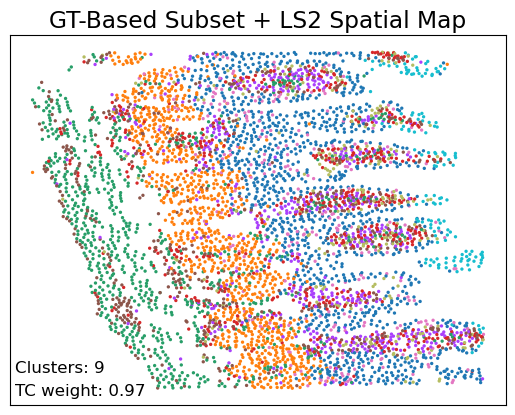

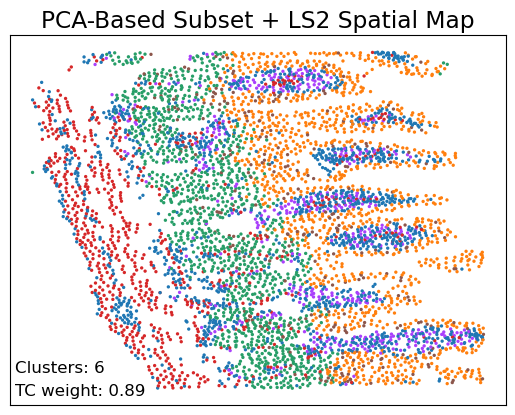

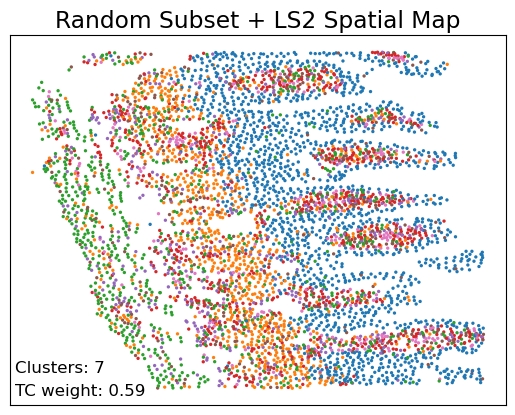

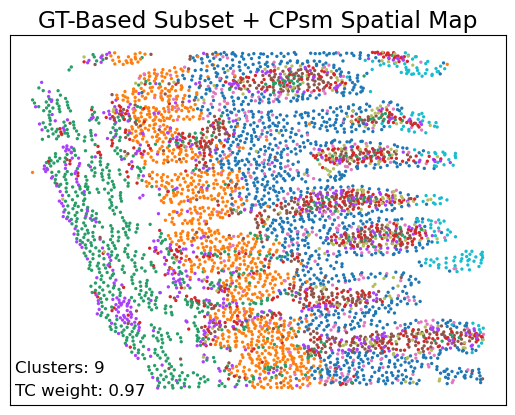

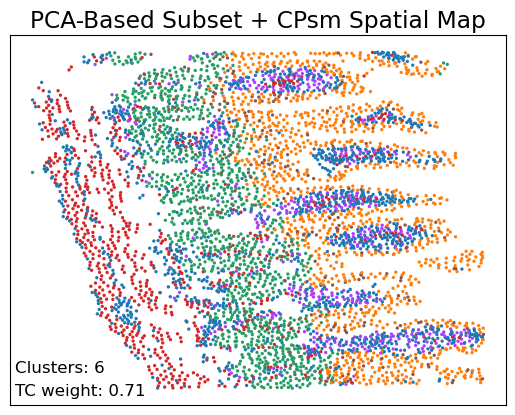

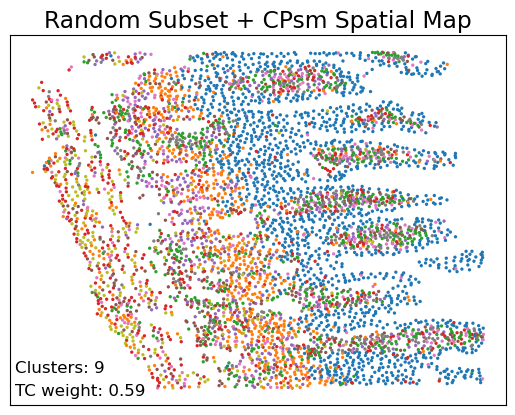

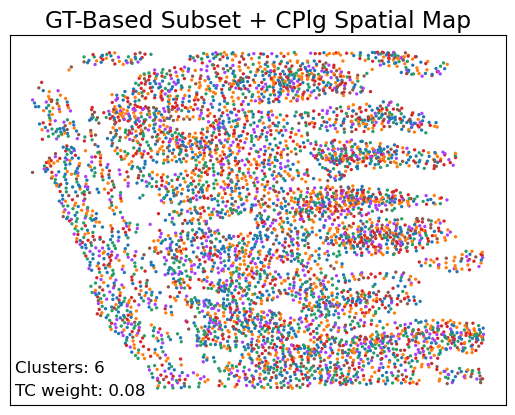

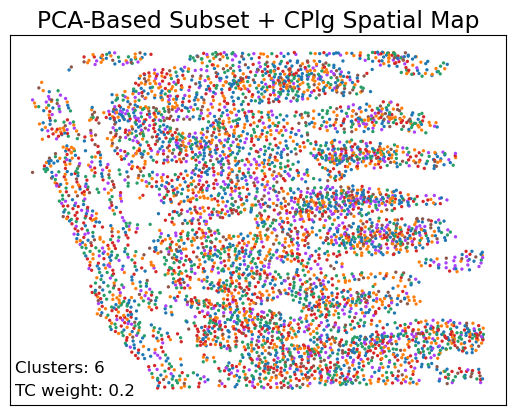

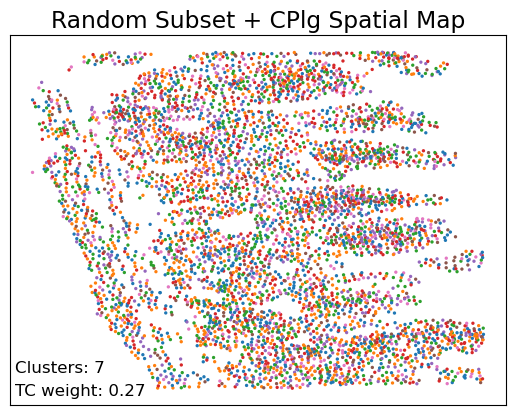

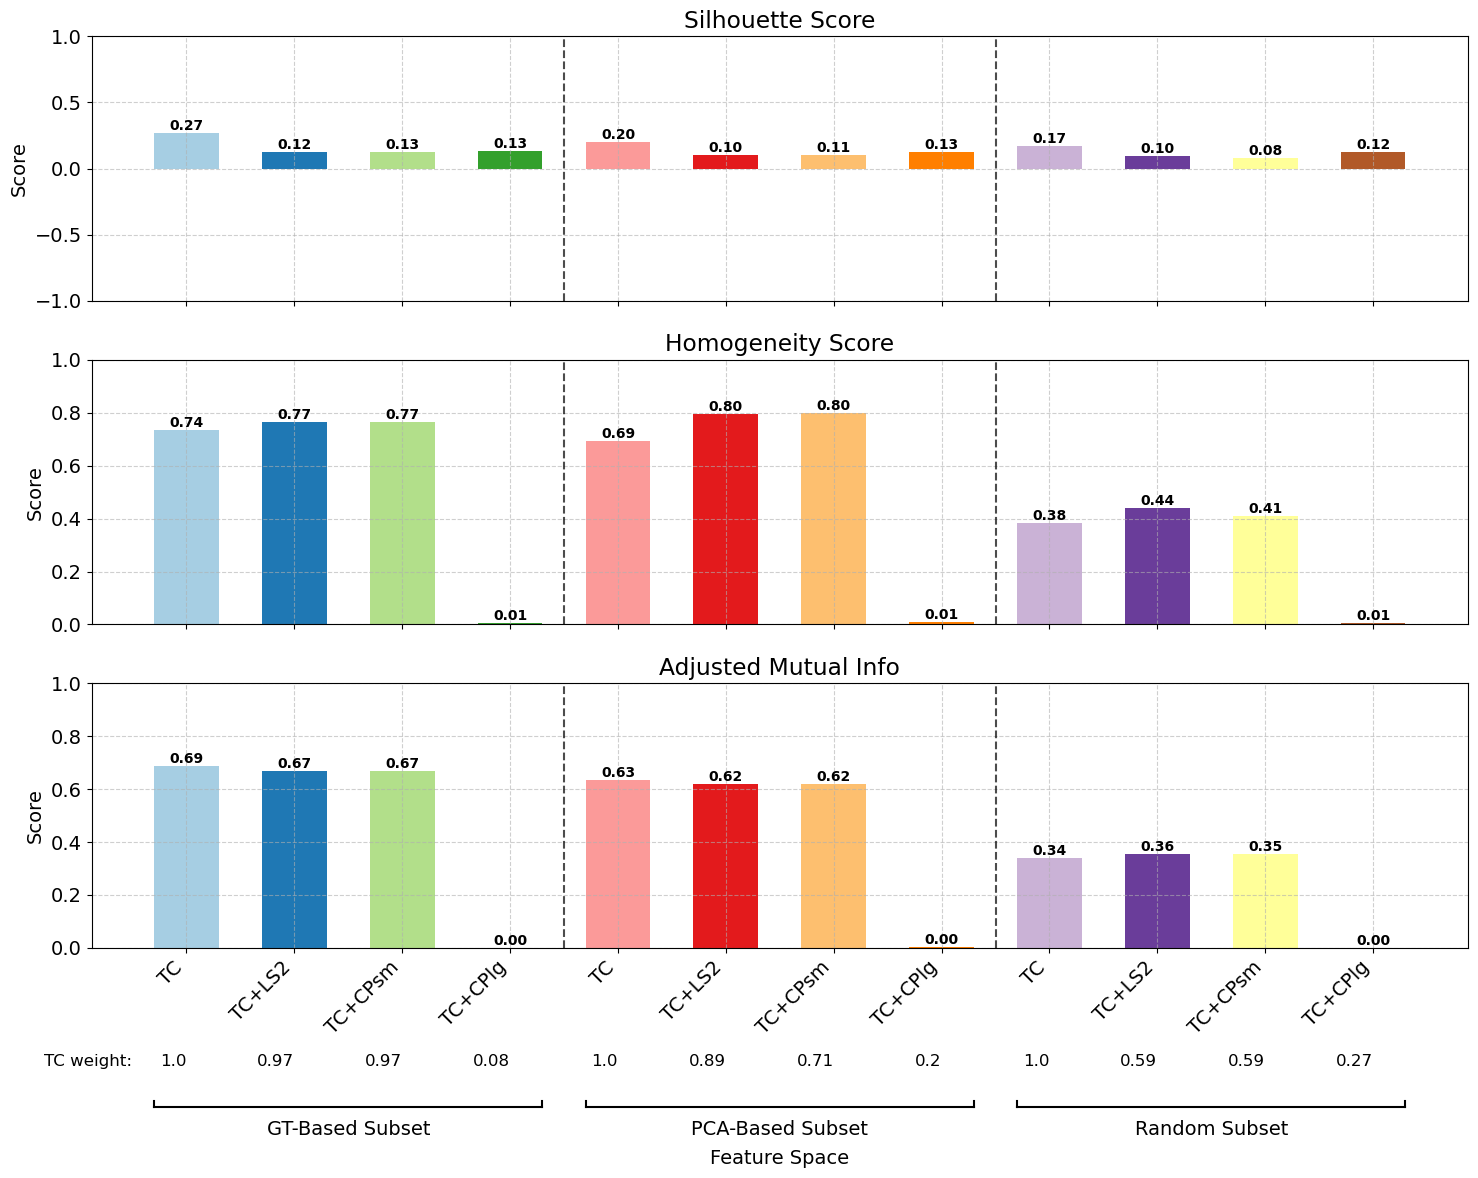

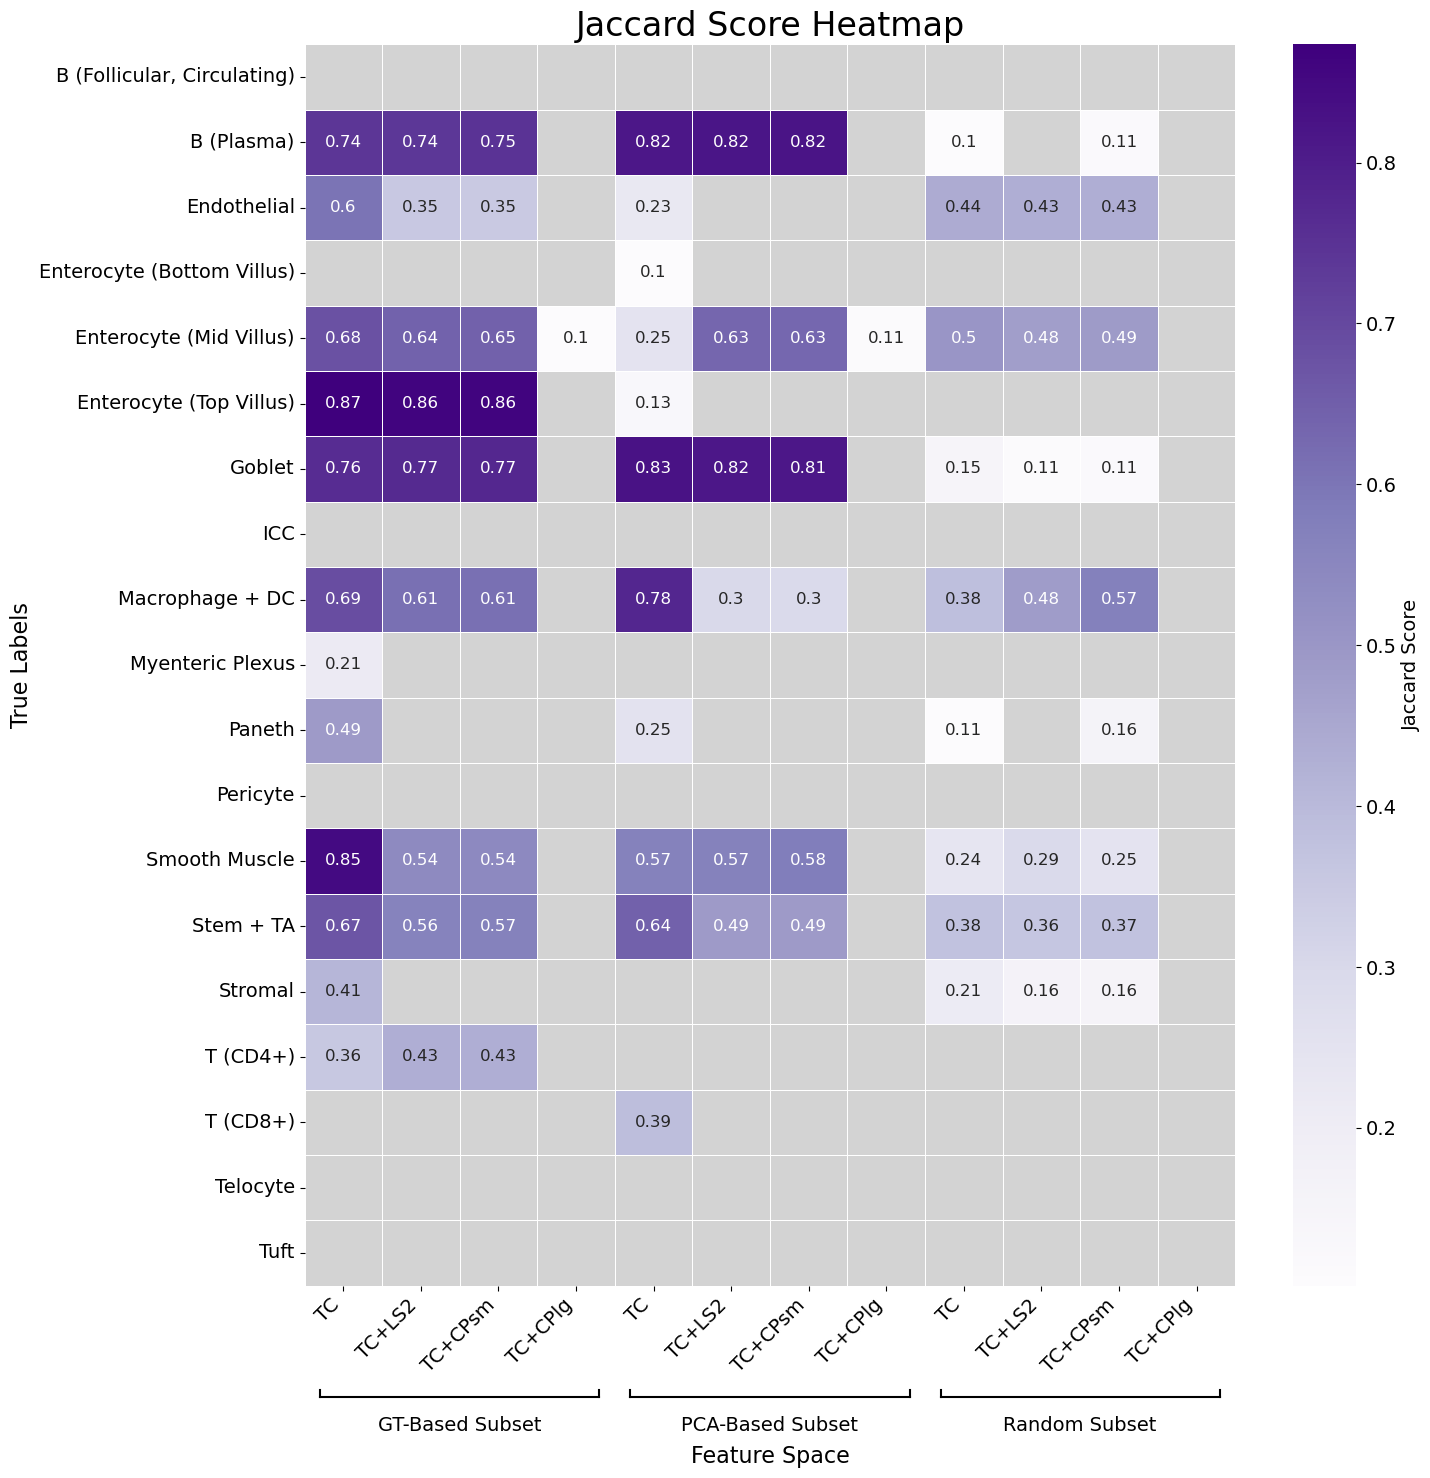

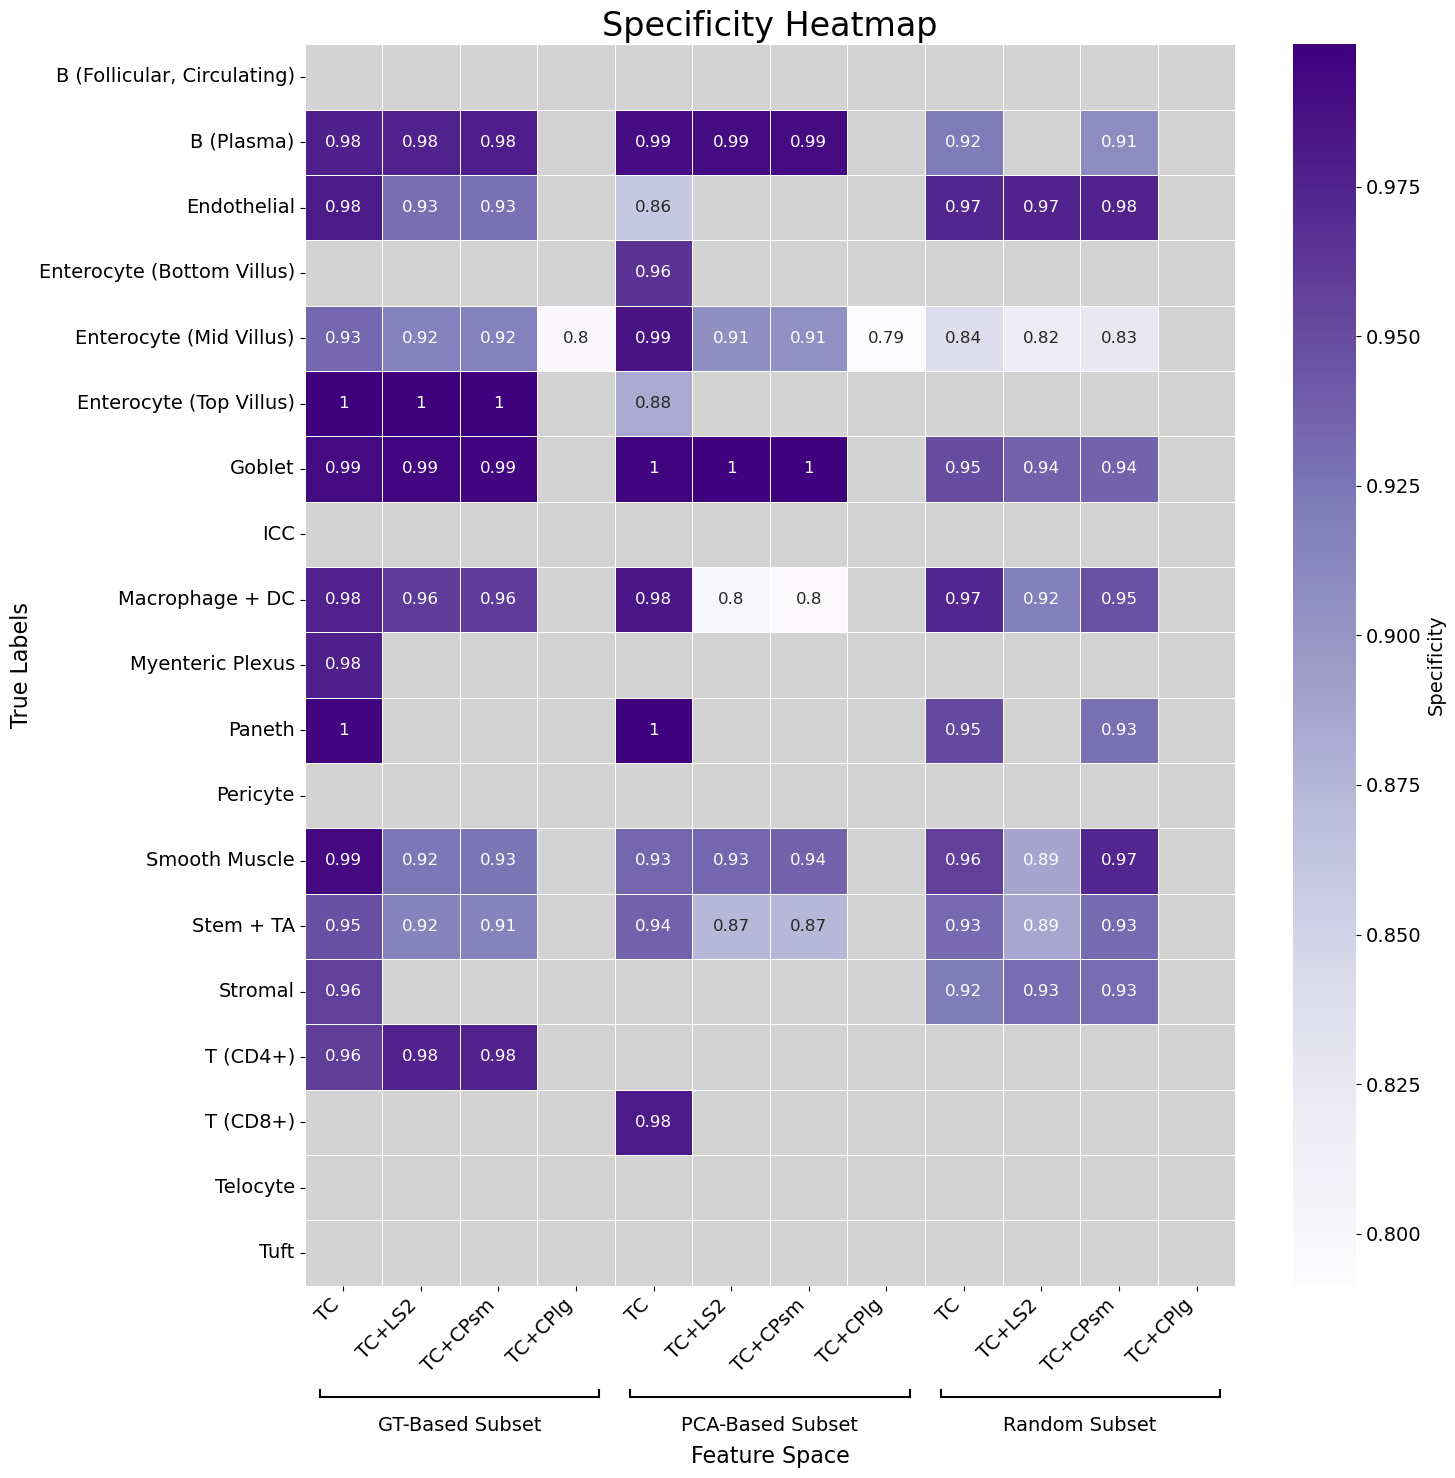

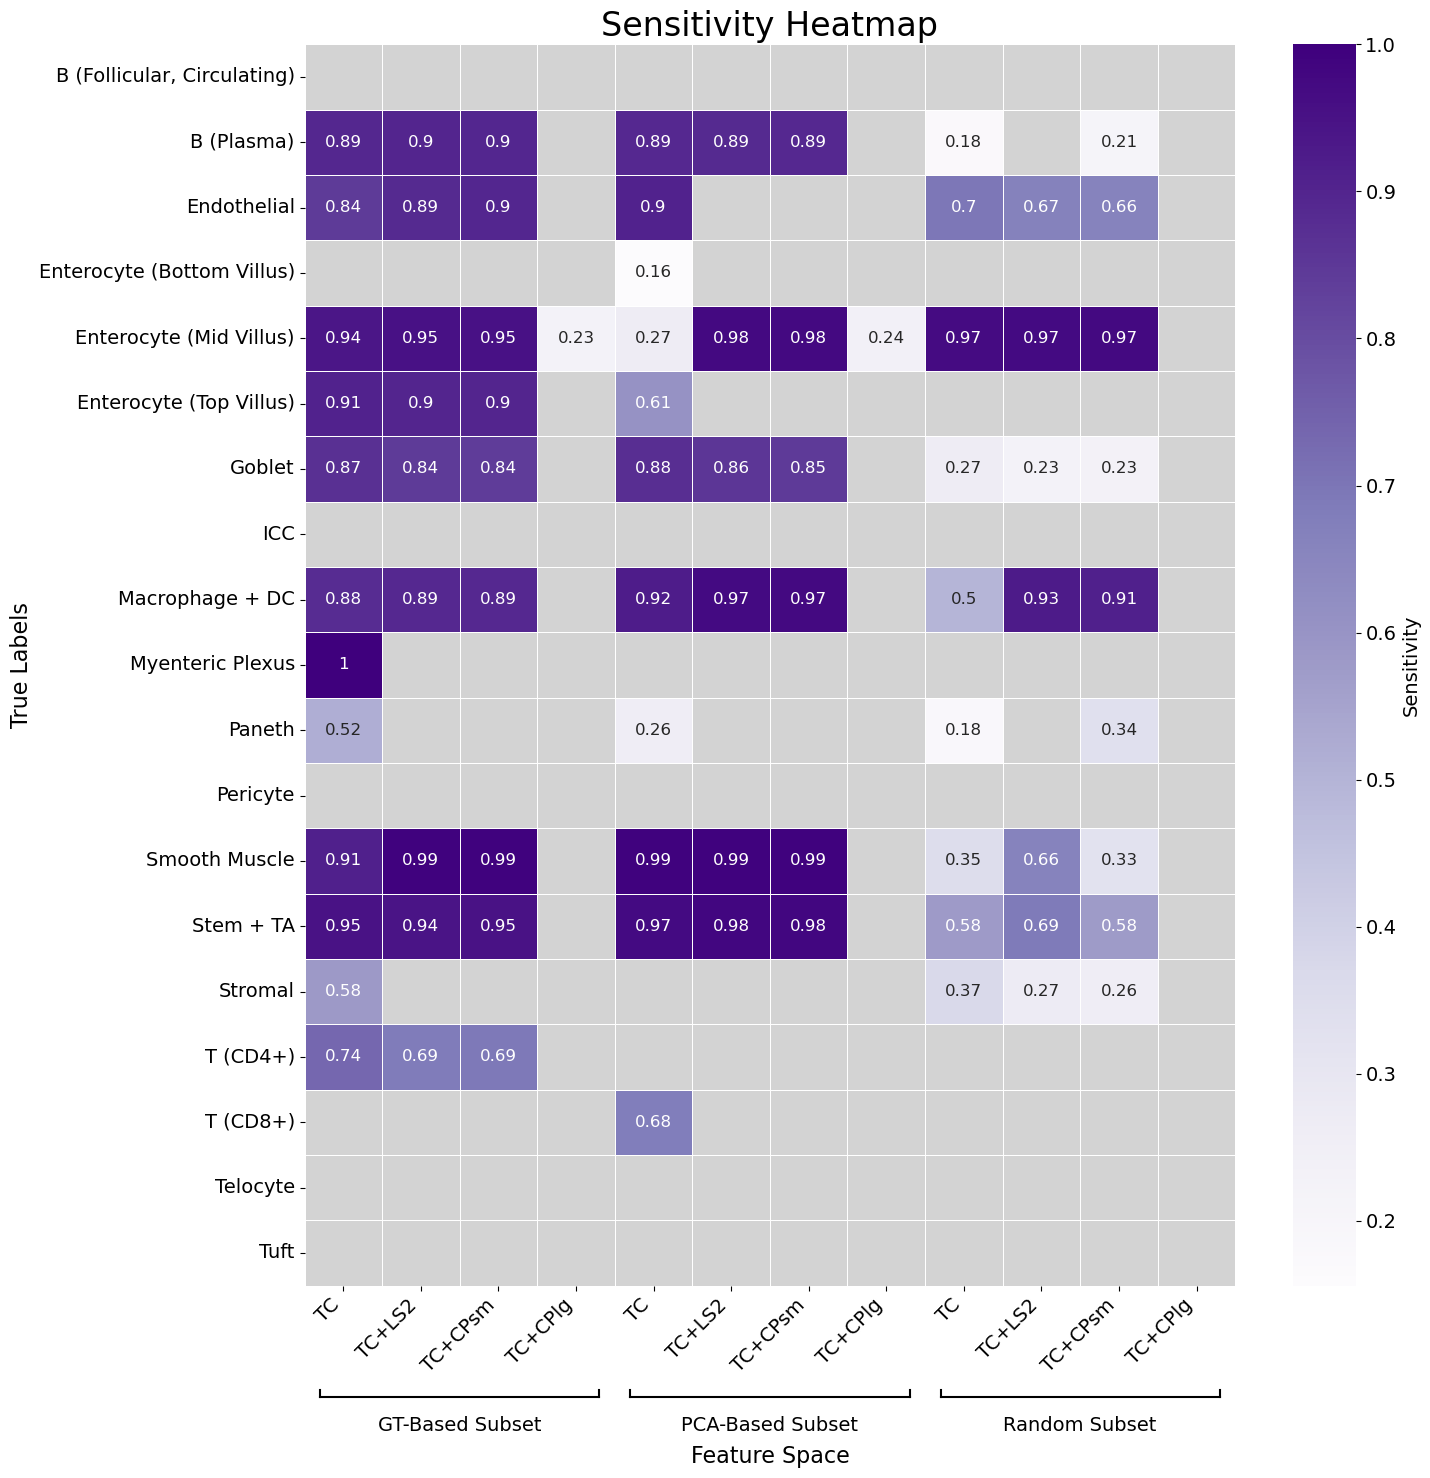

In [32]:
# Adding TC alone for comparison, inserting as first key
mdObjComboDict = {
    'GT-Based Subset': mdObjAll.mod['GT-Based Subset'],
    'PCA-Based Subset': mdObjAll.mod['PCA-Based Subset'],
    'Random Subset': mdObjAll.mod['Random Subset'], 
    **mdObjComboDict}

# Clustering combined modalities
for key, obj in mdObjComboDict.items():
    if isinstance(obj, sc.AnnData):
        continue # Skipping redundant spatial maps, redundant visual
        
    elif isinstance(obj, mu.MuData):
        name = list(obj.mod.keys())[0]
        mu.pl.embedding(obj, basis=f'{name}:spatial', color=['clusters'], title=f'{key} Spatial Map', legend_loc='none', show=False)
        # Adding title manually since (to resolve inconsistency due to different implementation of sc vs mu)
        plt.gca().set_title(f"{key} Spatial Map", fontsize=16.8)
        fileName = key.replace(' ', '_')
        indivModSpatialMapPath = outputDir + f'/spatial/{fileName}_spatial_map.png'
        
        # Adding nClusters as text
        nClusters = obj.obs['clusters'].nunique()
        plt.gca().text(0.01, 0.08, f'Clusters: {nClusters}',
                       horizontalalignment='left',
                       verticalalignment='bottom',
                       transform=plt.gca().transAxes,
                       fontsize=12, color='black')
        
        # Adding TC weight as text
        TC_weight = next(iter(optimalLeidenHyperparamsDict['MuData']['results'][key]['weights'].values()))
        plt.gca().text(0.01, 0.02, f'TC weight: {TC_weight}', 
                   horizontalalignment='left', 
                   verticalalignment='bottom', 
                   transform=plt.gca().transAxes, 
                   fontsize=12, color='black')
        
        # Dropping axis titles
        plt.gca().set_xlabel("")
        plt.gca().set_ylabel("")
        
        plt.savefig(indivModSpatialMapPath, dpi=600, bbox_inches="tight")

# Making a directory for combined modality analyses
os.makedirs(outputDir + '/combined_modality_metrics', exist_ok=True)
comboOutputDir = outputDir + '/combined_modality_metrics'

datasetCustomOrderList = ['GT-Based Subset', 'GT-Based Subset + LS2', 'GT-Based Subset + CPsm', 'GT-Based Subset + CPlg', 'PCA-Based Subset', 'PCA-Based Subset + LS2', 'PCA-Based Subset + CPsm', 'PCA-Based Subset + CPlg', 'Random Subset', 'Random Subset + LS2', 'Random Subset + CPsm', 'Random Subset + CPlg']

# Renaming for plot
datasetNameSubstitutionDict = {}
for dataset in datasetCustomOrderList:
    if '+' not in dataset:
        group = dataset
        newName = 'TC'
    else:
        group = dataset.split(' + ')[0]
        newName = f"TC+{dataset.split(' + ')[1]}"

    datasetNameSubstitutionDict[dataset] = {
        'group': group,
        'new_name': newName
    }

# Evaluate clustering using the function
evaluate_clustering(
    data_object_dictionary=mdObjComboDict,
    ground_truth_dataframe=preprocessedDFDict['cell_assignment'],
    output_directory=comboOutputDir,
    dataset_custom_order_list=datasetCustomOrderList,
    sort_labels=False,
    generate_interaction_plots=False,
    generate_specificity_heatmap=True,
    generate_sensitivity_heatmap=True,
    color_map='Purples',
    vertical_dashed_line_positions=(3,7),
    dataset_name_substitution_dict=datasetNameSubstitutionDict,
    leiden_optimization_results=optimalLeidenHyperparamsDict
)